<a href="https://colab.research.google.com/github/alan713/alan1/blob/master/HW_3_q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


In [2]:
# Adjust path if needed; if files are in your drive, mount and set paths
with open("small_vocab_en", "r", encoding="utf-8") as f:
    en_sentences = f.read().strip().split("\n")

with open("small_vocab_fr", "r", encoding="utf-8") as f:
    fr_sentences = f.read().strip().split("\n")

print(len(en_sentences), len(fr_sentences))
print("Example EN:", en_sentences[0])
print("Example FR:", fr_sentences[0])


FileNotFoundError: [Errno 2] No such file or directory: 'small_vocab_en'

In [3]:
!ls /content


sample_data  small_vocab_en.txt  small_vocab_fr.txt


In [5]:
EN_PATH = "/content/small_vocab_en.txt"
FR_PATH = "/content/small_vocab_fr.txt"



In [6]:
with open(EN_PATH, "r", encoding="utf-8") as f:
    en_sentences = f.read().strip().split("\n")

with open(FR_PATH, "r", encoding="utf-8") as f:
    fr_sentences = f.read().strip().split("\n")

print(len(en_sentences), len(fr_sentences))
print("EN example:", en_sentences[0])
print("FR example:", fr_sentences[0])


137860 137860
EN example: new jersey is sometimes quiet during autumn , and it is snowy in april .
FR example: new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


In [7]:
# Adjust path if needed; if files are in your drive, mount and set paths
with open("small_vocab_en", "r", encoding="utf-8") as f:
    en_sentences = f.read().strip().split("\n")

with open("small_vocab_fr", "r", encoding="utf-8") as f:
    fr_sentences = f.read().strip().split("\n")

print(len(en_sentences), len(fr_sentences))
print("Example EN:", en_sentences[0])
print("Example FR:", fr_sentences[0])


FileNotFoundError: [Errno 2] No such file or directory: 'small_vocab_en'

In [8]:
!pwd
!ls -lh /content


/content
total 19M
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 8.7M Nov 21 23:07 small_vocab_en.txt
-rw-r--r-- 1 root root 9.7M Nov 21 23:07 small_vocab_fr.txt


In [9]:
EN_PATH = "/content/small_vocab_en.txt"
FR_PATH = "/content/small_vocab_fr.txt"

with open(EN_PATH, "r", encoding="utf-8") as f:
    en_sentences = f.read().strip().split("\n")

with open(FR_PATH, "r", encoding="utf-8") as f:
    fr_sentences = f.read().strip().split("\n")

print(len(en_sentences), len(fr_sentences))
print("EN example:", en_sentences[0])
print("FR example:", fr_sentences[0])


137860 137860
EN example: new jersey is sometimes quiet during autumn , and it is snowy in april .
FR example: new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def tokenize_and_pad(sentences, oov_token="<UNK>"):
    tokenizer = Tokenizer(oov_token=oov_token, filters="")
    tokenizer.fit_on_texts(sentences)
    seqs = tokenizer.texts_to_sequences(sentences)
    max_len = max(len(s) for s in seqs)
    padded = pad_sequences(seqs, maxlen=max_len, padding="post")
    return padded, tokenizer, max_len

en_padded, en_tokenizer, max_en_len = tokenize_and_pad(en_sentences)
fr_padded, fr_tokenizer, max_fr_len = tokenize_and_pad(fr_sentences)

en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print("en_padded:", en_padded.shape)
print("fr_padded:", fr_padded.shape)
print("EN vocab:", en_vocab_size, "FR vocab:", fr_vocab_size)
print("max_en_len:", max_en_len, "max_fr_len:", max_fr_len)


en_padded: (137860, 17)
fr_padded: (137860, 23)
EN vocab: 229 FR vocab: 356
max_en_len: 17 max_fr_len: 23


In [11]:
N = en_padded.shape[0]
split_idx = int(0.9 * N)

X_train, X_val = en_padded[:split_idx], en_padded[split_idx:]
y_train, y_val = fr_padded[:split_idx], fr_padded[split_idx:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)


Train: (124074, 17) (124074, 23)
Val:   (13786, 17) (13786, 23)


In [12]:
def build_seq2seq(cell_type, units, en_vocab_size, fr_vocab_size,
                  max_en_len, max_fr_len, embedding_dim=128):
    """
    cell_type: 'rnn', 'lstm', or 'gru'
    units: hidden units per layer (e.g. 256)
    """
    encoder_inputs = layers.Input(shape=(max_en_len,), name=f"{cell_type}_encoder_input")
    x = layers.Embedding(en_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)

    # ----- Encoder (2 layers) -----
    if cell_type == "lstm":
        x = layers.LSTM(units, return_sequences=True)(x)
        encoder_output, state_h, state_c = layers.LSTM(units, return_sequences=False, return_state=True)(x)
        encoder_state = [state_h, state_c]
    elif cell_type == "gru":
        x = layers.GRU(units, return_sequences=True)(x)
        encoder_output, state_h = layers.GRU(units, return_sequences=False, return_state=True)(x)
        encoder_state = [state_h]
    else:  # 'rnn'
        x = layers.SimpleRNN(units, return_sequences=True)(x)
        encoder_output, state_h = layers.SimpleRNN(units, return_sequences=False, return_state=True)(x)
        encoder_state = [state_h]

    # ----- Decoder -----
    # Use the final encoder state as a compressed representation; repeat for each target timestep
    x = layers.RepeatVector(max_fr_len)(encoder_output)

    if cell_type == "lstm":
        x = layers.LSTM(units, return_sequences=True)(x)
        x = layers.LSTM(units, return_sequences=True)(x)
    elif cell_type == "gru":
        x = layers.GRU(units, return_sequences=True)(x)
        x = layers.GRU(units, return_sequences=True)(x)
    else:
        x = layers.SimpleRNN(units, return_sequences=True)(x)
        x = layers.SimpleRNN(units, return_sequences=True)(x)

    # Output: sequence of FR tokens
    decoder_outputs = layers.TimeDistributed(
        layers.Dense(fr_vocab_size, activation="softmax")
    )(x)

    model = models.Model(encoder_inputs, decoder_outputs, name=f"{cell_type}_seq2seq")
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [13]:
UNITS = 256
EPOCHS = 10   # raise if you have time; lower if not

models_dict = {}
histories = {}

for cell in ["rnn", "lstm", "gru"]:
    print(f"\n=== Training {cell.upper()} model ===")
    model = build_seq2seq(
        cell_type=cell,
        units=UNITS,
        en_vocab_size=en_vocab_size,
        fr_vocab_size=fr_vocab_size,
        max_en_len=max_en_len,
        max_fr_len=max_fr_len,
        embedding_dim=128,
    )
    model.summary()
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=128,
        epochs=EPOCHS,
        verbose=1,
    )
    models_dict[cell] = model
    histories[cell] = history



=== Training RNN model ===


Model: "rnn_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rnn_encoder_input   │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 17, 128)   │     29,312 │ rnn_encoder_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 17)        │          0 │ rnn_encoder_inpu… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 17, 256)   │     98,560 │ embedding[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ [(None, 256),     │    131,328 │ simple_rnn[0][0], │
│ (SimpleRNN)         │ (None, 256)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 23, 256)   │          0 │ simple_rnn_1[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 23, 256)   │    131,328 │ repeat_vector[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_3        │ (None, 23, 256)   │    131,328 │ simple_rnn_2[0][… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 23, 356)   │     91,492 │ simple_rnn_3[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 613,348 (2.34 MB)

 Trainable params: 613,348 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.5822 - loss: 1.7748 - val_accuracy: 0.7391 - val_loss: 0.8637
Epoch 2/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7722 - loss: 0.7477 - val_accuracy: 0.8218 - val_loss: 0.5618
Epoch 3/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8369 - loss: 0.5093 - val_accuracy: 0.8680 - val_loss: 0.4108
Epoch 4/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8708 - loss: 0.4019 - val_accuracy: 0.8755 - val_loss: 0.3979
Epoch 5/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8989 - loss: 0.3137 - val_accuracy: 0.9074 - val_loss: 0.2876
Epoch 6/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9143 - loss: 0.2668 - val_accuracy: 0.9203 - val_loss: 0.2482
Epoch 7/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9175 - loss: 0.2572 - val_accuracy: 0.9235 - val_loss: 0.2391
Epoch 8/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9296 - loss: 0.2195 - val_accuracy: 

Model: "lstm_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_encoder_input  │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 17, 128)   │     29,312 │ lstm_encoder_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 17)        │          0 │ lstm_encoder_inp… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 17, 256)   │    394,240 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 256),     │    525,312 │ lstm[0][0],       │
│                     │ (None, 256),      │            │ not_equal_1[0][0] │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 23, 256)   │          0 │ lstm_1[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 23, 256)   │    525,312 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 23, 256)   │    525,312 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 23, 356)   │     91,492 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,090,980 (7.98 MB)

 Trainable params: 2,090,980 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5145 - loss: 2.2338 - val_accuracy: 0.6518 - val_loss: 1.1854
Epoch 2/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6766 - loss: 1.0918 - val_accuracy: 0.7349 - val_loss: 0.8551
Epoch 3/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7477 - loss: 0.8072 - val_accuracy: 0.7764 - val_loss: 0.6908
Epoch 4/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7936 - loss: 0.6381 - val_accuracy: 0.8311 - val_loss: 0.5162
Epoch 5/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8429 - loss: 0.4816 - val_accuracy: 0.8753 - val_loss: 0.3896
Epoch 6/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8857 - loss: 0.3566 - val_accuracy: 0.9080 - val_loss: 0.2948
Epoch 7/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9181 - loss: 0.2634 - val_accuracy: 0.9335 - val_loss: 0.2234
Epoch 8/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9462 - loss: 0.1828 - 

Model: "gru_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gru_encoder_input   │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 17, 128)   │     29,312 │ gru_encoder_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 17)        │          0 │ gru_encoder_inpu… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 17, 256)   │    296,448 │ embedding_2[0][0… │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 256),     │    394,752 │ gru[0][0],        │
│                     │ (None, 256)]      │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 23, 256)   │          0 │ gru_1[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 23, 256)   │    394,752 │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 23, 256)   │    394,752 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 23, 356)   │     91,492 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,601,508 (6.11 MB)

 Trainable params: 1,601,508 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by GRU.call():
  • sequences=tf.Tensor(shape=(None, 17, 256), dtype=float32)
  • initial_state=None
  • mask=tf.Tensor(shape=(None, 17), dtype=bool)
  • training=True

In [14]:
from tensorflow.keras import layers, models

def build_seq2seq(cell_type, units,
                  en_vocab_size, fr_vocab_size,
                  max_en_len, max_fr_len,
                  embedding_dim=128):
    """
    cell_type: 'rnn', 'lstm', or 'gru'
    """
    encoder_inputs = layers.Input(shape=(max_en_len,), name=f"{cell_type}_encoder_input")

    # Note: NO mask_zero here to avoid masking/graph issues
    x = layers.Embedding(en_vocab_size, embedding_dim)(encoder_inputs)

    # ----- Encoder: 2 stacked layers -----
    if cell_type == "lstm":
        x = layers.LSTM(units, return_sequences=True)(x)
        x = layers.LSTM(units, return_sequences=False)(x)
    elif cell_type == "gru":
        x = layers.GRU(units, return_sequences=True)(x)
        x = layers.GRU(units, return_sequences=False)(x)
    else:  # 'rnn'
        x = layers.SimpleRNN(units, return_sequences=True)(x)
        x = layers.SimpleRNN(units, return_sequences=False)(x)

    # x is now the encoded sentence vector
    encoded = x

    # ----- Decoder: 2 stacked layers -----
    # Repeat encoded vector for each target timestep
    x = layers.RepeatVector(max_fr_len)(encoded)

    if cell_type == "lstm":
        x = layers.LSTM(units, return_sequences=True)(x)
        x = layers.LSTM(units, return_sequences=True)(x)
    elif cell_type == "gru":
        x = layers.GRU(units, return_sequences=True)(x)
        x = layers.GRU(units, return_sequences=True)(x)
    else:
        x = layers.SimpleRNN(units, return_sequences=True)(x)
        x = layers.SimpleRNN(units, return_sequences=True)(x)

    # Output: sequence of French tokens
    decoder_outputs = layers.TimeDistributed(
        layers.Dense(fr_vocab_size, activation="softmax")
    )(x)

    model = models.Model(encoder_inputs, decoder_outputs, name=f"{cell_type}_seq2seq")
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [15]:
UNITS = 256
EPOCHS = 5   # you can increase to 8–10 if it trains fast enough

models_dict = {}
histories = {}

for cell in ["rnn", "lstm", "gru"]:
    print(f"\n=== Training {cell.upper()} model ===")
    model = build_seq2seq(
        cell_type=cell,
        units=UNITS,
        en_vocab_size=en_vocab_size,
        fr_vocab_size=fr_vocab_size,
        max_en_len=max_en_len,
        max_fr_len=max_fr_len,
        embedding_dim=128,
    )
    model.summary()
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=128,
        epochs=EPOCHS,
        verbose=1,
    )
    models_dict[cell] = model
    histories[cell] = history



=== Training RNN model ===


Model: "rnn_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_encoder_input (InputLayer)  │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 17, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 17, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 23, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 23, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 23, 356)        │        91,492 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,348 (2.34 MB)

 Trainable params: 613,348 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.5543 - loss: 1.9950 - val_accuracy: 0.7014 - val_loss: 1.0082
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7492 - loss: 0.8409 - val_accuracy: 0.7896 - val_loss: 0.6776
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7991 - loss: 0.6432 - val_accuracy: 0.8218 - val_loss: 0.5583
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8315 - loss: 0.5265 - val_accuracy: 0.8444 - val_loss: 0.4797
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8545 - loss: 0.4494 - val_accuracy: 0.8693 - val_loss: 0.4089

=== Training LSTM model ===


Model: "lstm_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_encoder_input (InputLayer) │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 17, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 17, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 23, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 23, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 23, 356)        │        91,492 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,090,980 (7.98 MB)

 Trainable params: 2,090,980 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5198 - loss: 2.1985 - val_accuracy: 0.6750 - val_loss: 1.1191
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7014 - loss: 1.0058 - val_accuracy: 0.7452 - val_loss: 0.8251
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7561 - loss: 0.7800 - val_accuracy: 0.7875 - val_loss: 0.6577
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7970 - loss: 0.6253 - val_accuracy: 0.8272 - val_loss: 0.5230
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8399 - loss: 0.4857 - val_accuracy: 0.8724 - val_loss: 0.3873

=== Training GRU model ===


Model: "gru_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_encoder_input (InputLayer)  │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 17, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 17, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 23, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 23, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 23, 356)        │        91,492 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601,508 (6.11 MB)

 Trainable params: 1,601,508 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5211 - loss: 2.1697 - val_accuracy: 0.6913 - val_loss: 1.0746
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7091 - loss: 0.9938 - val_accuracy: 0.7489 - val_loss: 0.8253
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7575 - loss: 0.7831 - val_accuracy: 0.7975 - val_loss: 0.6306
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8036 - loss: 0.6102 - val_accuracy: 0.8282 - val_loss: 0.5360
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8477 - loss: 0.4712 - val_accuracy: 0.8835 - val_loss: 0.3733


In [16]:
index_to_fr = {idx: word for word, idx in fr_tokenizer.word_index.items()}
index_to_fr[0] = ""  # padding

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def translate_sentence(model, sentence, en_tokenizer, max_en_len, max_fr_len, index_to_fr):
    seq = en_tokenizer.texts_to_sequences([sentence])
    seq = pad_sequences(seq, maxlen=max_en_len, padding="post")
    preds = model.predict(seq)
    preds_ids = np.argmax(preds[0], axis=-1)
    words = [index_to_fr.get(idx, "") for idx in preds_ids if idx != 0]
    return " ".join(words).strip()


In [17]:
np.random.seed(0)
sample_indices = np.random.choice(len(en_sentences), size=10, replace=False)

for i in sample_indices:
    en = en_sentences[i]
    print(f"\nEN: {en}")
    for cell in ["rnn", "lstm", "gru"]:
        fr_pred = translate_sentence(
            models_dict[cell], en, en_tokenizer, max_en_len, max_fr_len, index_to_fr
        )
        print(f"{cell.upper()} -> {fr_pred}")



EN: the united states is usually warm during winter , and it is usually cold in march .
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
RNN -> les états-unis est généralement chaud pendant l' hiver , et il est jamais agréable en mars .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
LSTM -> les états-unis est généralement chaud pendant l' hiver , et il est généralement agréable en mars .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
GRU -> les états-unis est généralement chaud pendant l' hiver , et il est généralement froid en mars .

EN: he likes pears , peaches , and apples .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
RNN -> il aime les pêches , les pêches et les oranges .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
LSTM -> il aime les poires , les poires et les raisins .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GRU -> il aime les poires , les pommes et les pommes .

EN: paris is never hot during february , and it is relaxing in july .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
RNN -> paris est jamais chaud en février , et il es

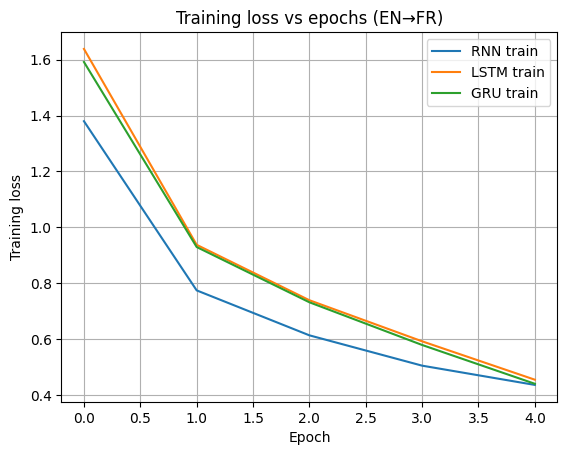

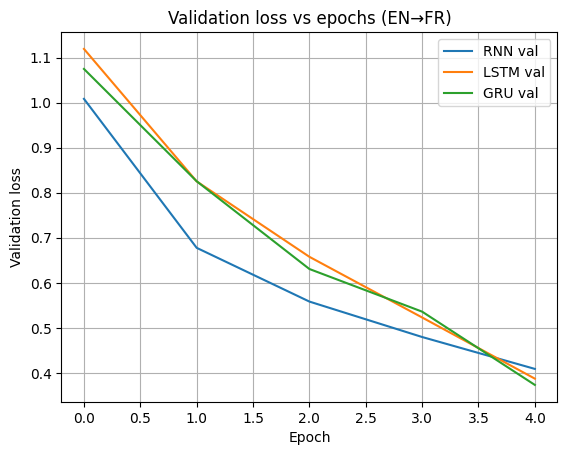

In [18]:
import matplotlib.pyplot as plt

# Training loss vs epochs for all three
plt.figure()
for cell, history in histories.items():
    plt.plot(history.history["loss"], label=f"{cell.upper()} train")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Training loss vs epochs (EN→FR)")
plt.grid(True)
plt.legend()
plt.show()

# Validation loss vs epochs for all three
plt.figure()
for cell, history in histories.items():
    plt.plot(history.history["val_loss"], label=f"{cell.upper()} val")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("Validation loss vs epochs (EN→FR)")
plt.grid(True)
plt.legend()
plt.show()


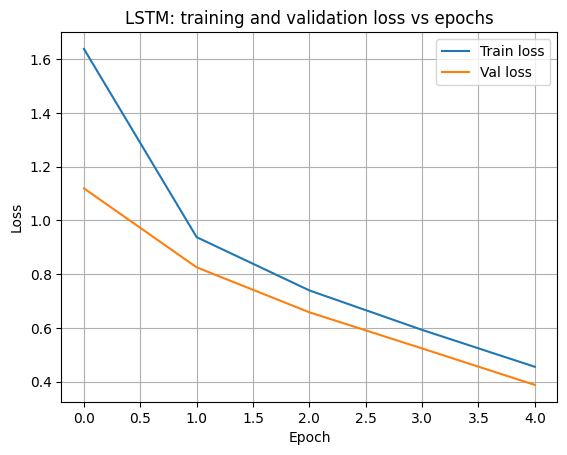

In [19]:
best_hist = histories["lstm"]   # or "gru" if that’s best

plt.figure()
plt.plot(best_hist.history["loss"], label="Train loss")
plt.plot(best_hist.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM: training and validation loss vs epochs")
plt.grid(True)
plt.legend()
plt.show()


In [20]:
import time
import numpy as np
import tensorflow as tf

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.cum_times = []
        self._start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self._epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        t = time.time() - self._epoch_start
        self.epoch_times.append(t)
        self.cum_times.append(time.time() - self._start_time)


In [21]:
time_cb = TimeHistory()

EPOCHS_TIME = 5  # keep small if you're low on time

lstm_time_model = build_seq2seq(
    cell_type="lstm",
    units=256,
    en_vocab_size=en_vocab_size,
    fr_vocab_size=fr_vocab_size,
    max_en_len=max_en_len,
    max_fr_len=max_fr_len,
    embedding_dim=128,
)

history_lstm_time = lstm_time_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=EPOCHS_TIME,
    callbacks=[time_cb],
    verbose=1,
)


Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5087 - loss: 2.2665 - val_accuracy: 0.6650 - val_loss: 1.1686
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6939 - loss: 1.0523 - val_accuracy: 0.7385 - val_loss: 0.8517
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7465 - loss: 0.8137 - val_accuracy: 0.7703 - val_loss: 0.7076
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7760 - loss: 0.6877 - val_accuracy: 0.8061 - val_loss: 0.5858
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8168 - loss: 0.5521 - val_accuracy: 0.8357 - val_loss: 0.4935


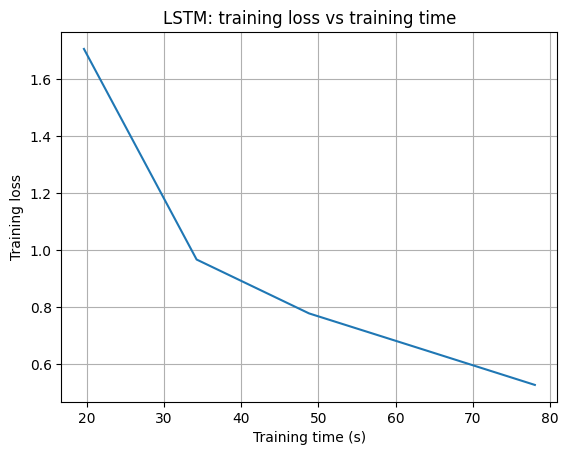

In [22]:
train_loss = history_lstm_time.history["loss"]
t = time_cb.cum_times

plt.figure()
plt.plot(t, train_loss)
plt.xlabel("Training time (s)")
plt.ylabel("Training loss")
plt.title("LSTM: training loss vs training time")
plt.grid(True)
plt.show()


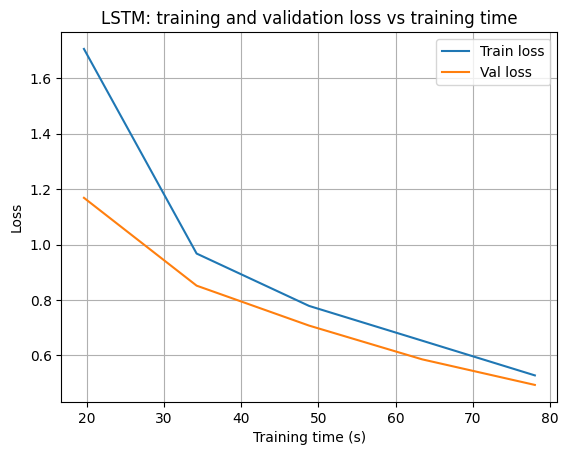

In [23]:
val_loss = history_lstm_time.history["val_loss"]

plt.figure()
plt.plot(t, train_loss, label="Train loss")
plt.plot(t, val_loss, label="Val loss")
plt.xlabel("Training time (s)")
plt.ylabel("Loss")
plt.title("LSTM: training and validation loss vs training time")
plt.grid(True)
plt.legend()
plt.show()


In [24]:
for cell, history in histories.items():
    train_loss = history.history["loss"][-1]
    val_loss = history.history["val_loss"][-1]
    train_acc = history.history["accuracy"][-1]
    val_acc = history.history["val_accuracy"][-1]

    print(f"{cell.upper()} model:")
    print(f"  Final train loss: {train_loss:.4f}")
    print(f"  Final val loss:   {val_loss:.4f}")
    print(f"  Final train acc:  {train_acc:.4f}")
    print(f"  Final val acc:    {val_acc:.4f}")
    print()


RNN model:
  Final train loss: 0.4361
  Final val loss:   0.4089
  Final train acc:  0.8588
  Final val acc:    0.8693

LSTM model:
  Final train loss: 0.4547
  Final val loss:   0.3873
  Final train acc:  0.8505
  Final val acc:    0.8724

GRU model:
  Final train loss: 0.4401
  Final val loss:   0.3733
  Final train acc:  0.8594
  Final val acc:    0.8835



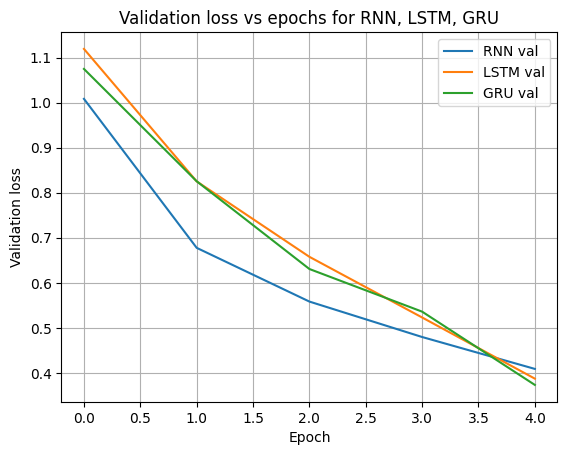

In [25]:
plt.figure()
for cell, history in histories.items():
    plt.plot(history.history["val_loss"], label=f"{cell.upper()} val")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("Validation loss vs epochs for RNN, LSTM, GRU")
plt.grid(True)
plt.legend()
plt.show()
